In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from logistic import LogisticRegression, GradientDescentOptimizer
from AdamOptimizer import AdamOptimizer

[AdamOptimizer.py](put the thing here)

### Introduction

The purpose of this blog post is to experiment with and investigate the ADAM optimizer, an alternative machine learning optimizer to Gradient Descent. By completing this blog post I plan to gain a lot more understanding of the ADAM optimizer itself as well as a better grasp of model optimization as a whole. The bulk of this blog is taken up by three repeated experiments running vanilla SGD and the ADAM optimizer on three different datasets and comparing the results in my case how quickly the models can converge via epochs and time. While my implementation of the ADAM optimizer often takes more time it can converge in few epochs than vanilla SGD.

### Data Loading

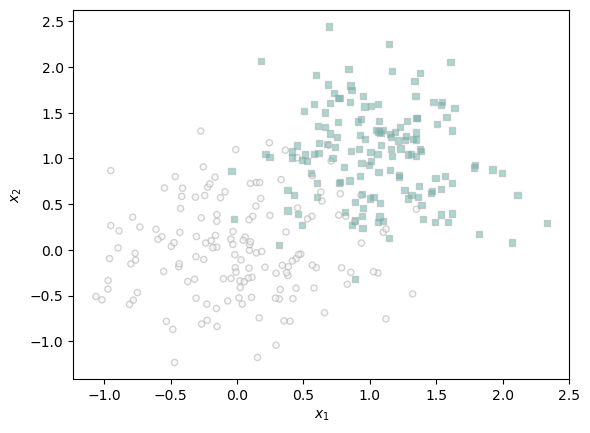

In [2]:
import torch
from matplotlib import pyplot as plt
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(noise = 0.5)
plot_classification_data(X, y, ax)

In [150]:
X_train, y_train = classification_data(n_points = 1000, noise = 0.5, p_dims = 10)
X_test, y_test = classification_data(n_points = 1000, noise = 0.5, p_dims = 10)

In [160]:
X_train.shape

torch.Size([1000, 11])

### Adam Implementation and Testing

In [149]:
import numpy as np
import time

def train_adam(model, digits_X, digits_y, alpha = 0.001, k_epochs=1, batch_size=192):
    st = time.time()
    data_loader_train = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(digits_X, digits_y),
        batch_size = batch_size,
        shuffle = True
    )

    opt = AdamOptimizer(model)
    losses = []
    weights = []
    w_prev = None

    for epoch in range(k_epochs):
        mini_losses = []
        for i, data in enumerate(data_loader_train):
            X, y = data
            mini_loss = model.loss(X, y)
            mini_losses.append(mini_loss.item())
            if w_prev == None:
                w_prev = model.w
            w = model.w
            weights.append(w)
            opt.step(X, y, alpha = alpha, beta_1 = 0.9, beta_2=0.999, w_0=w_prev)
            w_prev = w
        alpha = alpha/np.sqrt(epoch + 1)
        losses.append(np.mean(mini_losses))

    et = time.time()

    print(f'Elapsed time: {et - st} seconds')

    return losses, weights

In [57]:
import numpy as np
import time

def stochastic_train(model, X_train, y_train, alpha = 0.01, beta = 0.9, k_epochs = 1, batch_size = 32):
    st = time.time()
    data_loader_train = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size = batch_size,
        shuffle = True
    )

    # initialize training loop
    w = torch.zeros(X_train.size()[1], requires_grad=True)
    opt = GradientDescentOptimizer(model)
    losses = []
    weights = []
    w_prev = None

    # just do logistic regression here instead of mse

    for epoch in range(k_epochs):
        mini_losses = []
        for i, data in enumerate(data_loader_train):
            X, y = data
            # compute the loss
            mini_loss = model.loss(X, y)
            mini_losses.append(mini_loss.item())
            #losses.append(mini_loss.item())
            # compute the gradient
            mini_loss.backward()
            if w_prev == None:
                w_prev = model.w
            with torch.no_grad():
                opt.step(X, y, alpha = alpha, beta=beta, w_prev = w_prev)
            model.w.grad.zero_()
            weights.append(w)
        alpha = alpha/np.sqrt(epoch + 1)
        losses.append(np.mean(mini_losses))

    et = time.time()
    print(f'Elapsed time: {et - st} seconds')
    return losses, weights


In [161]:
LR_1 = LogisticRegression()
losses, weights = train_adam(LR_1, X_train, y_train, alpha=0.0001, k_epochs=20, batch_size=100)

Elapsed time: 29.513484001159668 seconds


In [168]:
LR_2 = LogisticRegression()
stoch_losses, stoch_weights = stochastic_train(LR_2, X_train, y_train, alpha = 0.2, beta = 0.0, k_epochs=20, batch_size=100)

Elapsed time: 0.18346333503723145 seconds


Text(0.5, 1.0, 'Stochastic Gradient Descent')

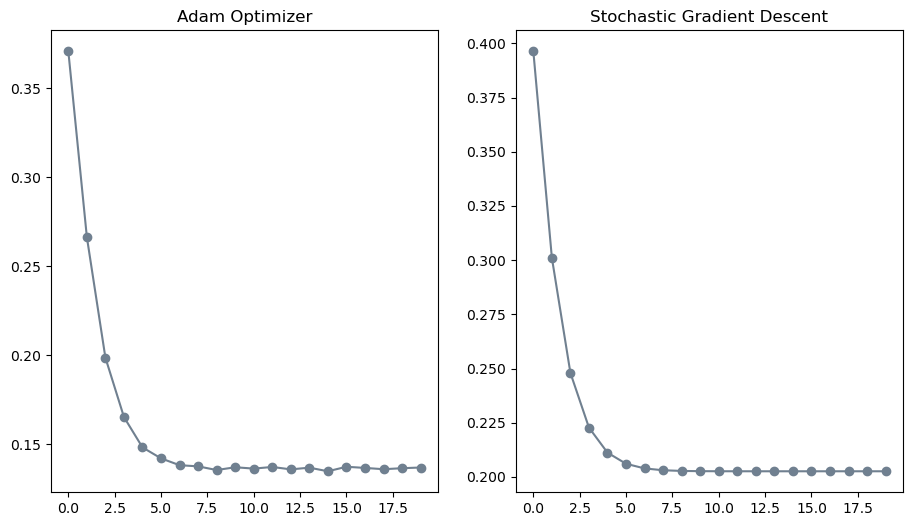

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(11,6))
ax[0].plot(losses, color = "slategrey")
ax[0].scatter(torch.arange(len(losses)), losses, color = "slategrey")
ax[1].plot(stoch_losses, color = "slategrey")
ax[1].scatter(torch.arange(len(stoch_losses)), stoch_losses, color = "slategrey")
ax[0].set_title('Adam Optimizer')
ax[1].set_title('Stochastic Gradient Descent')

Doing vanilla stochastic gradient descent I was able to achieve convergence significantly faster than using the Adam optimizer, with the run time of the cell taking just 0.18 seconds. The adam optimizer code took 29.5 seconds to run, but was able to achieve of a lower loss in about 5 epochs while the SGD achieved a higher loss convergence at about 6 epochs.

### Digits Analysis

Load the digits dataset

In [20]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [279]:
digits.target.shape

(1797,)

In [251]:
type(digits), type(digits.data)

(sklearn.utils._bunch.Bunch, numpy.ndarray)

Filter the digits dataset to just contain 1s and 0s

In [21]:
test_X, test_y = digits.data, digits.target

filtered_indices = (test_y == 1) | (test_y == 0)

test_X = test_X[filtered_indices]
test_y = test_y[filtered_indices]

Convert to torch tensors

In [22]:
digits_X = torch.Tensor(test_X)
digits_y = torch.Tensor(test_y)

Here we normalize the digits dataset to avoid errors when calculating the loss within `LogisticRegression`

In [23]:
digits_X /= 255

Use main training loops to compare vanilla SGD to ADAM optimizer.

In [25]:
LR_adam = LogisticRegression()
LR_sgd = LogisticRegression()

adam_losses, adam_weights = train_adam(LR_adam, digits_X, digits_y, alpha = 0.001, k_epochs=20, batch_size=64)
SGD_losses, SGD_weights = stochastic_train(LR_sgd, digits_X, digits_y, alpha = 200, beta = 0.9, k_epochs=20, batch_size=64)


Elapsed time: 14.235490798950195 seconds
Elapsed time: 0.07415390014648438 seconds


Plot training results

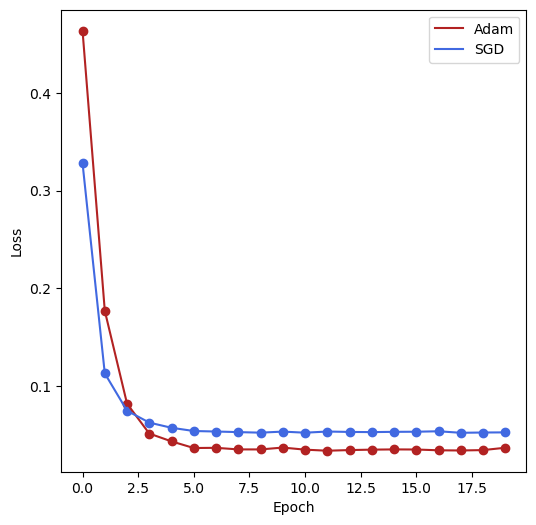

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(adam_losses, color = "firebrick", label="Adam")
ax.plot(SGD_losses, color = "royalblue", label="SGD")
ax.scatter(torch.arange(len(adam_losses)), adam_losses, color = "firebrick")
ax.scatter(torch.arange(len(SGD_losses)), SGD_losses, color = "royalblue")
ax.set(xlabel = r"Epoch", ylabel = r"Loss")
ax.legend(loc="upper right")

From the above plot we can see that the Adam optimizer can achieve a lower convergence loss, but with a much smaller learning rate and over a longer time frame. It took the Adam training loop about 14.2 seconds to execute while it took the stochastic gradient descent training loop only 0.7 seconds to execute. SGD also converged at an earlier epoch than the Adam optimizer did, at around 3 as opposed to epoch 4 or 5.

### Palmer Penguins Testing

For my third experiment I am going to use the palmer penguins data from our first blog post.

In [81]:
import pandas as pd
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

Parse through dataset and split into features and target values

In [82]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

I am hardcoding the features that I want which are taken from my first blog post as I know these work well for predicting the target values we want. Before creating the torch tensors for model training I also need to conver the boolean values returned from `pd.get_dummies()` to be float values.

In [101]:
cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
X_train = X_train[cols]

X_train[cols] = X_train[cols].astype(float)

for c in cols:
    X_train[c] = X_train[c] / X_train[c].max()

X_peng = torch.Tensor(X_train.values)
y_peng = torch.Tensor(y_train)

Model training loop to compare vanilla SGD and ADAM

In [145]:
LR_adam = LogisticRegression()
LR_sgd = LogisticRegression()

adam_losses, adam_weights = train_adam(LR_adam, X_peng, y_peng, alpha = 0.000035, k_epochs=10, batch_size=32)
SGD_losses, SGD_weights = stochastic_train(LR_sgd, X_peng, y_peng, alpha = .15, beta = 0.9, k_epochs=10, batch_size=32)

Elapsed time: 10.041518688201904 seconds
Elapsed time: 0.044052839279174805 seconds


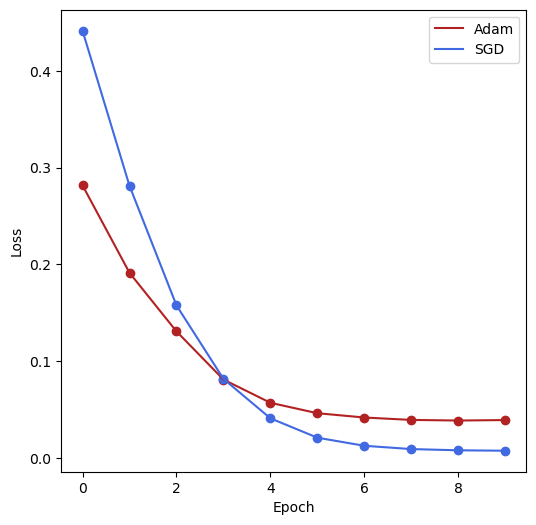

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.plot(adam_losses, color = "firebrick", label="Adam")
ax.plot(SGD_losses, color = "royalblue", label="SGD")
ax.scatter(torch.arange(len(adam_losses)), adam_losses, color = "firebrick")
ax.scatter(torch.arange(len(SGD_losses)), SGD_losses, color = "royalblue")
ax.set(xlabel = r"Epoch", ylabel = r"Loss")
ax.legend(loc="upper right")

Looking at the above plot we see that SGD and ADAM converge around the same time, with ADAM maybe convergin an epoch before SGD, but SGD reaches a lower converged loss. Interestingly using the palmer penguin dataset the data seems a lot more sensitive to very slightly changes to the learning rate. Compared to the digits dataset the SGD learning rate is significantly smaller and ADAM's lr for this test is also smaller than it has been in the previous comparisons. Similar to the previous steps ADAM takes a lot longer to run than SGD with the timing for this test being 10.04 seconds for ADAM and 0.04 seconds for SGD to run.

### Summary

Looking back on the results that were seen during this experiment I didn't quite reach the levels of efficiency described in the ADAM paper. While I did see ADAM generally converging in fewer epochs than SGD the runtime was significantly longer for ADAM than for SGD. While I didn't exactly see the efficiency of ADAM the author of the ADAM paper points out the ADAM's ability to deal with sparse gradients as one of the reasons it is efficient and uses less memory. It also is smart with its step-size choice which contributes to being an important part of ADAM's update rule. Additionally as the gradient changes the magnitudes of update parameters aren't affected.

As I mentioned previously I did not see the hyper-efficiency the paper describes ADAM as having and I think that is partly from my implementation of ADAM, under professor Phil's guidance to reach "convergence" in my adam optimizer I just loop over my optimization loop 1000 times, this loop for every step is bound to increase the runtime of ADAM and decrease some of the efficiency that I would expect to see. I also imagine that if I used a smaller learning rate across more epochs to compare both my SGD and ADAM I might see a wider margin of efficiency.

I actually had a much easier time implemeting ADAM than I did implementing stochastic gradient descent. While doing this blog post I have greatly increased my understanding of stochastic gradient descent I think I went into this work a little under prepared and so when trying to implement my version of SGD I ran into many issues while with ADAM some of the math of the implementation was complicated, but it was pretty straightforward to implement once I got past that. But overall I really enjoyed this blog post and thought it was a great learning experience.